# **Data Cleaning**

## Objectives
---

* Train an ML pipeline.
* Tune the pipeline using Hyperparameter Optimisation.
* Define the best features for predicting SalePrice.

## Steps
---

* Load data from the cleaned data outputs
* Perform a Grid Search CV with SKlearn.

## Import Necessary Packages
---

In [1]:
import numpy as np
import pandas as pd

## Change working directory
---

First we set the working directory for the notebook.

In [2]:
import os
current_dir = os.getcwd()
current_dir
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(current_dir)

/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor


## Load Data
---

Load the data in from the outputs section of the last notebook. We can drop the SalePrice column as it is the target varialbe in this study.

In [3]:
import pandas as pd
df = pd.read_csv('inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv')
df_clean = pd.read_csv("outputs/datasets/cleaned/clean_house_price_records.csv")
train_set = pd.read_csv("outputs/datasets/cleaned/train_set.csv")
test_set = pd.read_csv("outputs/datasets/cleaned/test_set.csv")

Change objects to categories.

In [4]:
categorical_variables = df.select_dtypes(include=['object']).columns
df[categorical_variables] = df[categorical_variables].astype('category')
df_clean[categorical_variables] = df_clean[categorical_variables].astype('category')
train_set[categorical_variables] = train_set[categorical_variables].astype('category')
test_set[categorical_variables] = test_set[categorical_variables].astype('category')

Load pipelines from outputs.

In [5]:
import joblib
data_cleaning_pipeline = joblib.load("outputs/pipelines/data_cleaning_pipeline.pkl")
feature_engineering_pipeline = joblib.load("outputs/pipelines/feature_engineering_pipeline.pkl")

In [6]:
data_cleaning_pipeline

Pipeline(steps=[('DropFeat',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['MasVnrArea', '2ndFlrSF',
                                              'LotFrontage'])),
                ('CategoricalImputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['GarageFinish', 'BsmtFinType1',
                                               'KitchenQual'])),
                ('ModalImputer',
                 CategoricalImputer(ignore_format=True,
                                    imputation_method='frequent',
                                    variables=['GarageYrBlt',
                                               'BedroomAbvGr']))])

In [7]:
feature_engineering_pipeline

Pipeline(steps=[('OrdinalEncoder',
                 OrdinalEncoder(variables=['GarageFinish', 'BsmtFinType1',
                                           'BsmtExposure', 'KitchenQual'])),
                ('LogTransform',
                 LogTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea',
                                           'LotFrontage'])),
                ('YeoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['YearBuilt',
                                                  'YearRemodAdd'])),
                ('PowerTransform',
                 PowerTransformer(variables=['BsmtUnfSF', 'GarageArea',
                                             'MasVnrArea', 'OpenPorchSF',
                                             'TotalBsmtSF'])),
                ('SmartFeatureSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='cardinality',
                                          threshold=0.6))])

Define complete pipeline for Optimization. This function returns a base pipeline that we can modify with different models.

In [8]:
from sklearn.pipeline import Pipeline

### Feat Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler


### ML algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ('data_cleaning_pipeline', data_cleaning_pipeline),
        ('feature_engineering_pipeline', feature_engineering_pipeline),
        ('FeatureScaling', StandardScaler()),
        ('FeatureSelection', SelectFromModel(model)),
        ('model', model)
        ])
    return pipeline_base


## Hyperparameter Optimization
---

This is a custom class taken from the codeinstitute modules regarding machine learning. It allows us to loop through different algorithms and hyperparameters to find the best performing combinations for a given pipeline.

In [9]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

We split the train and test data from the dataset.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1),
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Grid Search CV
---

* We first perform a search for the best Algorithm using default hyperparameters.
* We define the algorithms and the blank hyperparameters below.

In [11]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

We perform the initial search.

In [12]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)



Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa

Evaluating the results shows the best Regressor as the ExtraTreesRegressor.

In [182]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
0,RandomForestRegressor,0.6975,0.792888,0.8432,0.049778,6,100
4,RandomForestRegressor,0.692594,0.790803,0.841517,0.050937,None,100
2,RandomForestRegressor,0.689953,0.790744,0.839409,0.051848,18,100
10,ExtraTreesClassifier,0.668556,0.788442,0.841685,0.06123,None,20
9,ExtraTreesClassifier,0.64372,0.788341,0.84335,0.073054,18,50
6,ExtraTreesClassifier,0.689605,0.787915,0.834467,0.050554,6,20
5,RandomForestRegressor,0.685188,0.78777,0.842137,0.053806,None,700
11,ExtraTreesClassifier,0.656694,0.787682,0.842582,0.066664,None,50
3,RandomForestRegressor,0.683588,0.787595,0.842057,0.054433,18,700
1,RandomForestRegressor,0.688238,0.787471,0.844946,0.053212,6,700


## Results
---

* An R2 score of at least 0.75 is required as per the business requirements.
* The ExtraTreesRegressor meets this requirement at a mean score of 0.79
* We can now tune the Hyperparameters to further raise the score.

## Extensive search
---

We can now perform an extensive Hyperparameter search using the ExtraTreesRegressor algorithm.

### Define Model Parameters

In [14]:
models_search = {
    "ExtraTreesClassifier": ExtraTreesRegressor(random_state=0),
    'LinearRegression': LinearRegression(),
    }

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
params_search = {
    "ExtraTreesClassifier":{"model__n_estimators": [20,50],
                            'model__max_depth': [6,18,None],
                        },
    'LinearRegression': {},
}


In [15]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=8)


Running GridSearchCV for ExtraTreesClassifier 

Fitting 8 folds for each of 6 candidates, totalling 48 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa


Running GridSearchCV for LinearRegression 

Fitting 8 folds for each of 1 candidates, totalling 8 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa

We can see marginal improvements from this optimization.

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
0,ExtraTreesClassifier,0.615585,0.794415,0.865291,0.076257,6,20
1,ExtraTreesClassifier,0.632071,0.793334,0.865114,0.071015,6,50
3,ExtraTreesClassifier,0.544061,0.791816,0.870948,0.09788,18,50
2,ExtraTreesClassifier,0.522091,0.786391,0.881141,0.104159,18,20
4,ExtraTreesClassifier,0.497636,0.786377,0.881699,0.113897,None,20
5,ExtraTreesClassifier,0.508298,0.785162,0.879914,0.11057,None,50
6,LinearRegression,0.707605,0.777812,0.847692,0.047803,NaN,NaN


## Fit Best Result to Model
---

We can now fit the ExtraTreesClassifier to the Model with its tuned hyperparameters.

In [17]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesClassifier'

Define best regressor parameters.

In [18]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 6, 'model__n_estimators': 20}

In [19]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('data_cleaning_pipeline',
                 Pipeline(steps=[('DropFeat',
                                  DropFeatures(features_to_drop=['EnclosedPorch',
                                                                 'WoodDeckSF'])),
                                 ('MeanMedianImputer',
                                  MeanMedianImputer(variables=['MasVnrArea',
                                                               '2ndFlrSF',
                                                               'LotFrontage'])),
                                 ('CategoricalImputer',
                                  CategoricalImputer(imputation_method='frequent',
                                                     variables=['GarageFinish',
                                                                'BsmtFinType1',
                                                                'KitchenQual'])...
                                                              'MasVnrArea',
                                                              'OpenPorchSF',
                                                              'TotalBsmtSF'])),
                                 ('SmartFeatureSelection',
                                  SmartCorrelatedSelection(method='spearman',
                                                           selection_method='cardinality',
                                                           threshold=0.6))])),
                ('FeatureScaling', StandardScaler()),
                ('FeatureSelection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=6, n_estimators=20,
                                     random_state=0))])

## Assess Feature Importance
---

We can try to make the model more efficient by assessing the feature importance and dropping features that don't impact our final R2 score significantly.

* These are the 4 most important features in descending order. The model was trained on them: 
['GarageArea', 'GrLivArea', 'OverallQual', 'YearBuilt']


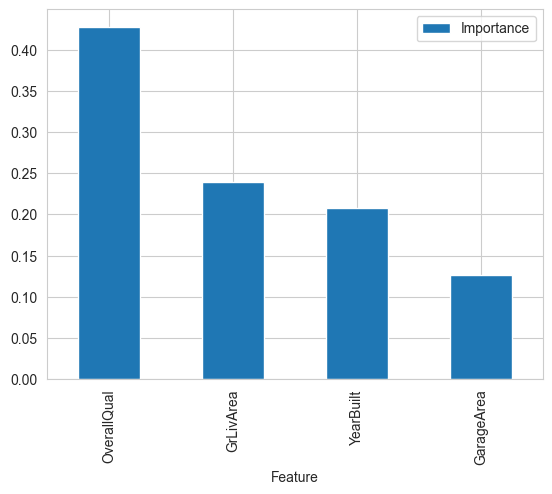

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

data_cleaning_feat_eng_steps = 2 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['FeatureSelection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['FeatureSelection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate Pipeline Performance
---

In [26]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.861
Mean Absolute Error: 20570.967
Mean Squared Error: 853775994.072
Root Mean Squared Error: 29219.445


* Test Set
R2 Score: 0.836
Mean Absolute Error: 21960.729
Mean Squared Error: 1132035333.797
Root Mean Squared Error: 33645.733




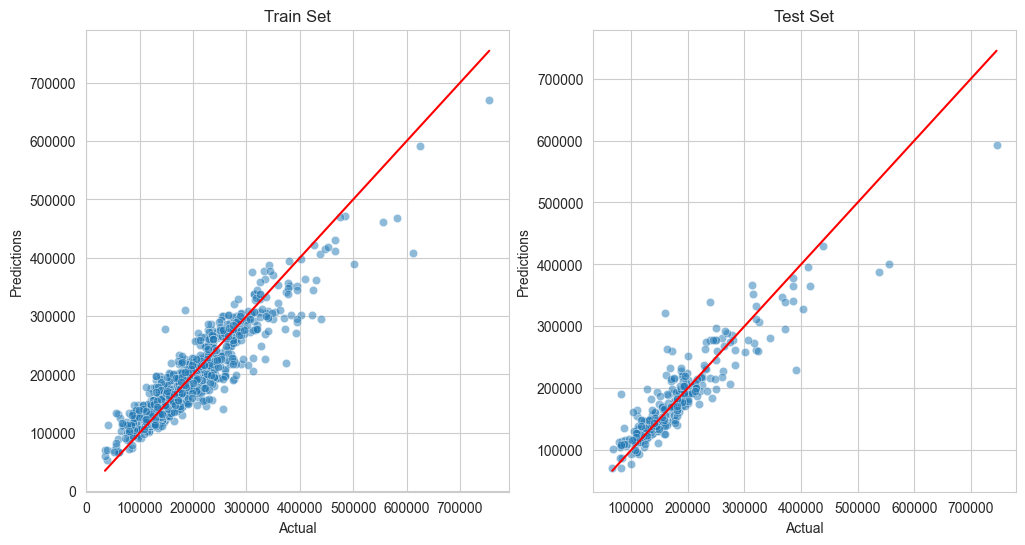

In [23]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

## Applying a Regressor with PCA
---

* We may be able to further improve the model by using PCA.

In [33]:
pipeline = PipelineOptimization(model=ExtraTreesRegressor())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'],axis=1), df['SalePrice'])

print(df_pca.shape,'\n', type(df_pca))

(1460, 16) 
 <class 'numpy.ndarray'>


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


We can see that a 7 component analysis contains 76.4% of the data. +-2 on this Value cahncged the output R2 score marginally.

* The 7 components explain 76.44% of the data 



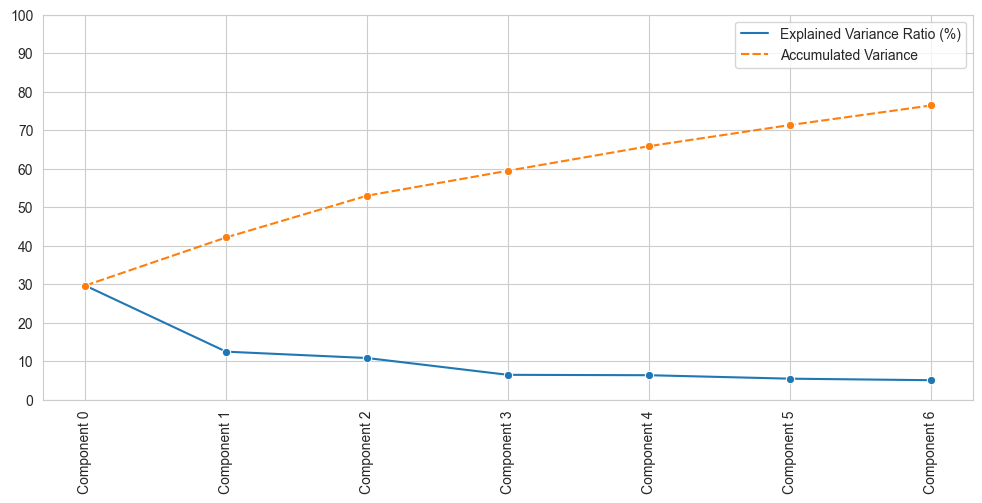

In [109]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 7

def pca_components_analysis(df_pca,n_components): 
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca) # array with transformed PCA

    ComponentsList = ["Component " + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data= np.round(100 * pca.explained_variance_ratio_ ,3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum() 

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12,5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_components_analysis(df_pca=df_pca,n_components=n_components)

## Rewrite ML Pipeline with PCA
---

We re-write the pipeline, this time without feature selection, instead we use our PCA with 7 components.

In [110]:
from sklearn.decomposition import PCA

selection_method = 'cardinality'
corr_method = 'spearman'
n_components = 7

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ('data_cleaning_pipeline', data_cleaning_pipeline),
        ('feature_engineering_pipeline', feature_engineering_pipeline),
        ('FeatureScaling', StandardScaler()),
        ("PCA", PCA(n_components=n_components, random_state=0)),
        ('model', model)
        ])
    return pipeline_base


In [111]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


Using Standard Hyperparameters

In [112]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Perform quick search

In [113]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa

Check results

In [114]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.765376,0.819033,0.879879,0.037503
3,ExtraTreesRegressor,0.695752,0.81574,0.882612,0.065108
5,GradientBoostingRegressor,0.713412,0.792891,0.831767,0.041875
6,XGBRegressor,0.696006,0.791815,0.843334,0.057352
4,AdaBoostRegressor,0.703957,0.776518,0.820563,0.043831
0,LinearRegression,0.689142,0.760317,0.802179,0.040192
1,DecisionTreeRegressor,0.529598,0.656265,0.750848,0.092171


In [115]:
models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
    "ExtraTreesClassifier": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesClassifier":{"model__n_estimators": [20,50],
                            'model__max_depth': [6,18,None],
                        },
    "RandomForestRegressor":{
        'model__n_estimators': [100,700],
        'model__max_depth': [6,18,None],
    }
}

In [116]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa


Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/matthewmurnaghan/Data-Science-Projects/AI-Projects/House-Price-Predictor/.venv/lib/python3.10/site-pa

Check the results.

In [117]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
5,RandomForestRegressor,0.768914,0.8221,0.87916,0.0368,None,700
3,RandomForestRegressor,0.76991,0.822053,0.877457,0.035844,18,700
2,RandomForestRegressor,0.772336,0.820786,0.876461,0.034294,18,100
4,RandomForestRegressor,0.765376,0.819033,0.879879,0.037503,None,100
11,ExtraTreesClassifier,0.707804,0.818028,0.881101,0.060277,None,50
0,RandomForestRegressor,0.767937,0.81691,0.870511,0.033608,6,100
1,RandomForestRegressor,0.756927,0.815584,0.869376,0.036942,6,700
9,ExtraTreesClassifier,0.704516,0.814445,0.881346,0.06074,18,50
8,ExtraTreesClassifier,0.698397,0.812703,0.88011,0.063717,18,20
10,ExtraTreesClassifier,0.684941,0.809276,0.870228,0.065828,None,20


Extract the best model

In [118]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

Check best parameters.

In [119]:
grid_search_pipelines[best_model].best_params_


{'model__max_depth': None, 'model__n_estimators': 700}

Define the best regressor model.

In [120]:
best_regressor_pipeline_pca = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline_pca

Pipeline(steps=[('data_cleaning_pipeline',
                 Pipeline(steps=[('DropFeat',
                                  DropFeatures(features_to_drop=['EnclosedPorch',
                                                                 'WoodDeckSF'])),
                                 ('MeanMedianImputer',
                                  MeanMedianImputer(variables=['MasVnrArea',
                                                               '2ndFlrSF',
                                                               'LotFrontage'])),
                                 ('CategoricalImputer',
                                  CategoricalImputer(imputation_method='frequent',
                                                     variables=['GarageFinish',
                                                                'BsmtFinType1',
                                                                'KitchenQual'])...
                                  PowerTransformer(variables=['BsmtUnfSF',
                                                              'GarageArea',
                                                              'MasVnrArea',
                                                              'OpenPorchSF',
                                                              'TotalBsmtSF'])),
                                 ('SmartFeatureSelection',
                                  SmartCorrelatedSelection(method='spearman',
                                                           selection_method='cardinality',
                                                           threshold=0.6))])),
                ('FeatureScaling', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model',
                 RandomForestRegressor(n_estimators=700, random_state=0))])

## Evaluation
---

Evaluate the PCA regressor on the train and test set.

Model Evaluation 

* Train Set
R2 Score: 0.975
Mean Absolute Error: 7546.962
Mean Squared Error: 150990347.286
Root Mean Squared Error: 12287.813


* Test Set
R2 Score: 0.768
Mean Absolute Error: 23192.897
Mean Squared Error: 1601733672.233
Root Mean Squared Error: 40021.665




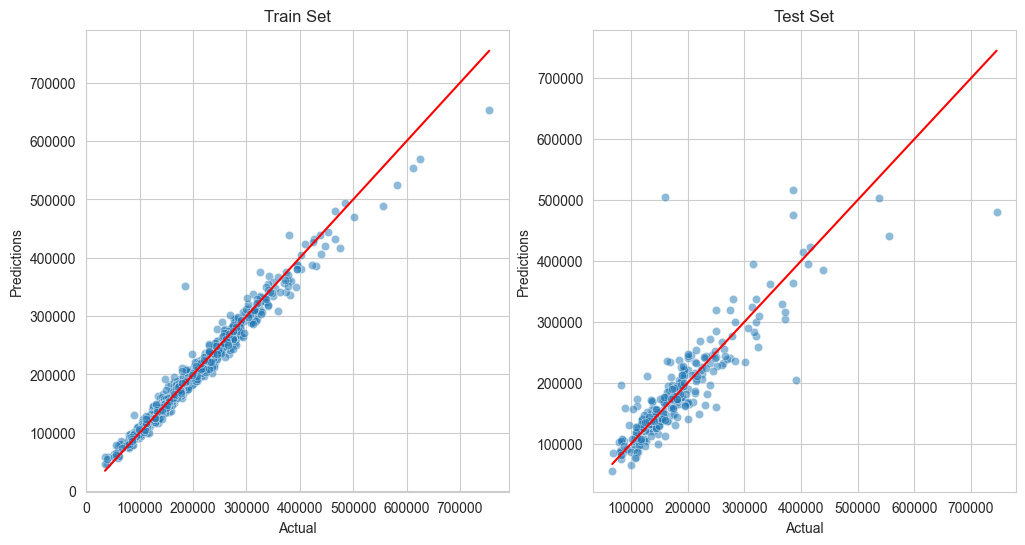

In [121]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline_pca)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline_pca)

## Subset Best Features
---

We can now subset the best features revealed by the PCA.

In [122]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)
X_train.head()

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


,GarageArea,GrLivArea,OverallQual,YearBuilt
618,774,1828,9,2007
870,308,894,5,1962
92,432,964,5,1921
817,857,1689,8,2002
302,843,1541,7,2001


We then rewrite the pipeline again.

In [129]:
from feature_engine.transformation import PowerTransformer
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.transformation import LogTransformer
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ('LogTransform', LogTransformer(variables=['GrLivArea',])),
        ('YeoJohnsonTransform', YeoJohnsonTransformer(variables=['YearBuilt',])),
        ('PowerTransform', PowerTransformer(variables=['GarageArea',])),
        ('FeatureScaling', StandardScaler()),
        ('model', model)
        ])
    return pipeline_base

We evaluate the pipeline using the previously established best algorithms.

In [152]:
models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
    "ExtraTreesClassifier": ExtraTreesRegressor(random_state=0),
}

We run the extended search using the recommended hyperparameters.

In [157]:
params_search = {
    "ExtraTreesClassifier":{"model__n_estimators": [20,50],
                            'model__max_depth': [6,18,None],
                        },
    "RandomForestRegressor":{
        'model__n_estimators': [100,700],
        'model__max_depth': [6,18,None],
    }
}

In [158]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [159]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__n_estimators
0,RandomForestRegressor,0.6975,0.792888,0.8432,0.049778,6,100
4,RandomForestRegressor,0.692594,0.790803,0.841517,0.050937,None,100
2,RandomForestRegressor,0.689953,0.790744,0.839409,0.051848,18,100
10,ExtraTreesClassifier,0.668556,0.788442,0.841685,0.06123,None,20
9,ExtraTreesClassifier,0.64372,0.788341,0.84335,0.073054,18,50
6,ExtraTreesClassifier,0.689605,0.787915,0.834467,0.050554,6,20
5,RandomForestRegressor,0.685188,0.78777,0.842137,0.053806,None,700
11,ExtraTreesClassifier,0.656694,0.787682,0.842582,0.066664,None,50
3,RandomForestRegressor,0.683588,0.787595,0.842057,0.054433,18,700
1,RandomForestRegressor,0.688238,0.787471,0.844946,0.053212,6,700


We can now extract the best Algorithm and set of Hyperparameters.

In [160]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

In [161]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('LogTransform', LogTransformer(variables=['GrLivArea'])),
                ('YeoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['YearBuilt'])),
                ('PowerTransform', PowerTransformer(variables=['GarageArea'])),
                ('FeatureScaling', StandardScaler()),
                ('model', RandomForestRegressor(max_depth=6, random_state=0))])

In [162]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 6, 'model__n_estimators': 100}

## Final Feature Importance Assessment
---

We now assess the feature importance, using the refitted pipieline and features.

* These are the 4 most important features in descending order. The model was trained on them: 
Index(['GarageArea', 'GrLivArea', 'OverallQual', 'YearBuilt'], dtype='object')


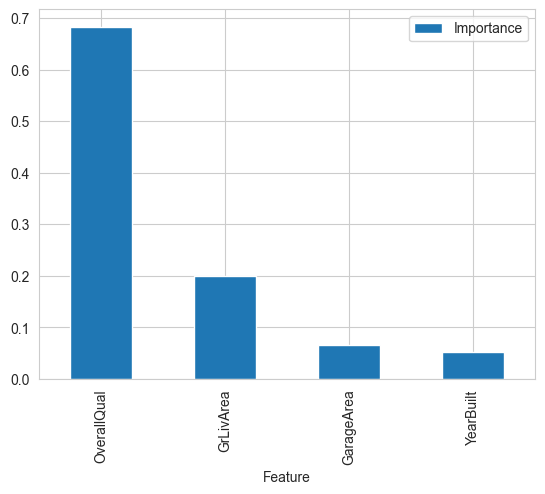

In [163]:
data_cleaning_feat_eng_steps = 3 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

We can see from the above graphic that by far, OverallQual has the most prominent effect on the prediction of the house prices.

Model Evaluation 

* Train Set
R2 Score: 0.894
Mean Absolute Error: 18228.01
Mean Squared Error: 654154012.379
Root Mean Squared Error: 25576.435


* Test Set
R2 Score: 0.811
Mean Absolute Error: 22351.032
Mean Squared Error: 1306490677.695
Root Mean Squared Error: 36145.41




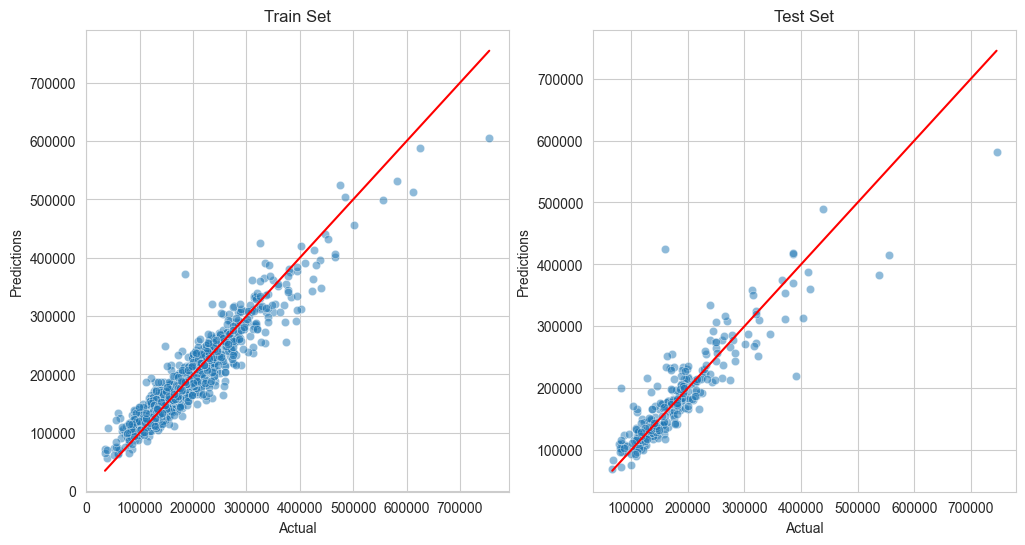

In [164]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

* We have achieved a final score of 0.894 on the train set and 0.811 on the test set.
* This indicates that the model is slightly overfitting.
* We have achieved our business goal and delivered a tuned and optimized model that provides an R2 score of 0.811 on the test data.

## Save Model and Dataset
---

* We can now save the model and the dataset to the outputs folder.
* We will also save the Features Importance plot.

In [165]:
import os

version = 'v1'
file_path = f'outputs/pipelines/predict_saleprice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

### Train Set


**Features**

In [168]:
print(X_train.shape,)
X_train.head(5)

(1168, 4)


,GarageArea,GrLivArea,OverallQual,YearBuilt
618,774,1828,9,2007
870,308,894,5,1962
92,432,964,5,1921
817,857,1689,8,2002
302,843,1541,7,2001


In [169]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)


**Target**

In [170]:
print(y_train.shape)
y_train.head()

(1168,)


618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [171]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)


### Test Set

**Features**

In [172]:
print(X_test.shape)
X_test.head()

(292, 4)


,GarageArea,GrLivArea,OverallQual,YearBuilt
529,484,2515,6,1957
491,240,1578,6,1941
459,352,1203,5,1950
279,505,2022,7,1977
655,264,1092,6,1971


In [173]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)


**Target**

In [174]:
print(y_test.shape)
y_test.head()

(292,)


529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [175]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)


## Model Pipeline

In [176]:
best_regressor_pipeline

Pipeline(steps=[('LogTransform', LogTransformer(variables=['GrLivArea'])),
                ('YeoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['YearBuilt'])),
                ('PowerTransform', PowerTransformer(variables=['GarageArea'])),
                ('FeatureScaling', StandardScaler()),
                ('model', RandomForestRegressor(max_depth=6, random_state=0))])

In [177]:
import joblib
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/pipelines/predict_saleprice/v1/best_regressor_pipeline.pkl']

### Feature Importance Plot

In [178]:
df_feature_importance.to_csv(f"{file_path}/feature_importance.csv", index=False)

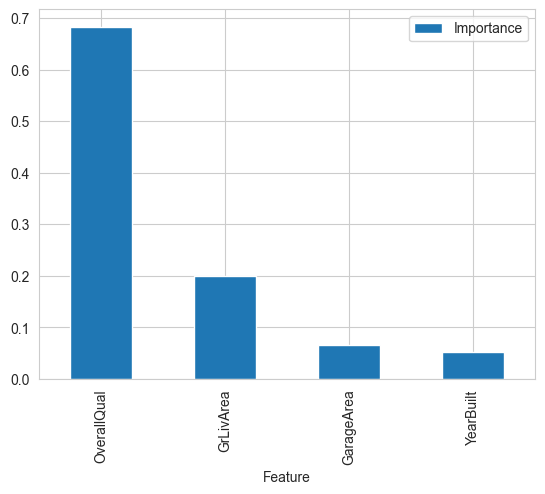

In [179]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature_importance.png', bbox_inches='tight')

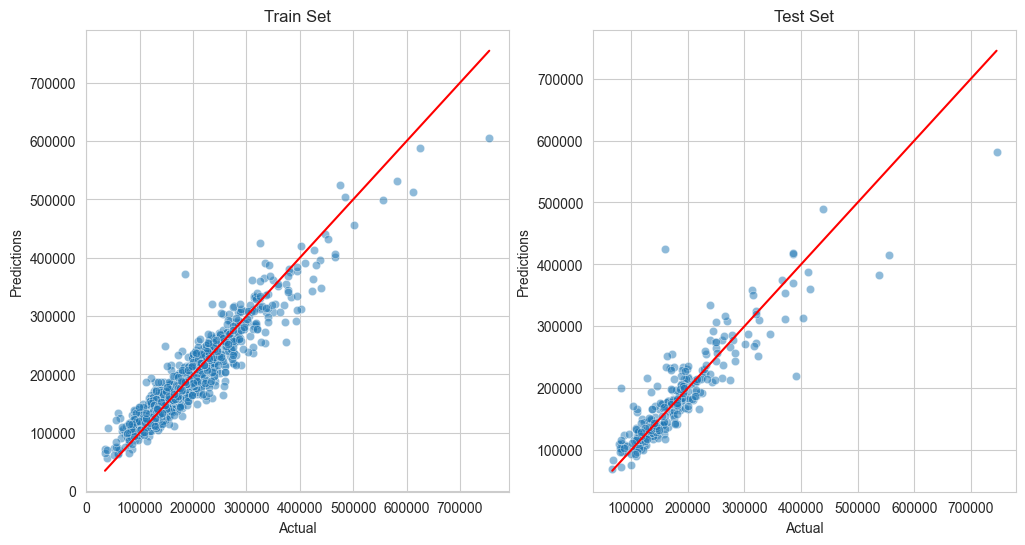

In [181]:

pred_train = best_regressor_pipeline.predict(X_train)
pred_test = best_regressor_pipeline.predict(X_test)
alpha_scatter=0.5

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predictions")
axes[0].set_title("Train Set")

sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predictions")
axes[1].set_title("Test Set")

plt.savefig(f'{file_path}/regression_evaluation_plots.png', bbox_inches='tight')

## Conclusion
---

* The Regressor for predicting the House Price has been selected as the RandomForrestRegressor.
* The Feature Selection Pipeline performed slightly better, achieving a result of 0.836 on the test set and 0.861 on the train set.
* Using either Pipeline, the business requirement has veen met, and an R2 score of greater than 0.75 has been achieved.